# Far-Field to Local Boundary Coupling Analysis

This notebook analyzes whether far-field switching influences a local boundary region through a small number of smooth/low-frequency spatial patterns.

**Core Question**: Given a locality window W with boundary ports B, does the matrix H of far-field block responses (restricted to B) have low rank?

## Methodology

1. Define locality window W (2D rectangular region)
2. Define boundary set B = all ports inside W
3. Partition far-field into K blocks (tiles outside W)
4. For each block k: inject current pattern s_k, solve coupled system, extract boundary voltages h_k
5. Stack responses: H = [h_1, h_2, ..., h_K]
6. Compute SVD(H) and analyze singular value decay

In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List, Set, Any, Tuple

# Project imports
from pdn.pdn_parser import NetlistParser
from core import create_model_from_pdn, UnifiedIRDropSolver
from core.tiling import TileManager
from core.farfield_analysis import (
    run_farfield_analysis,
    define_window_and_boundary,
    compute_window_bounds,
    partition_farfield_into_blocks,
    partition_farfield_by_distance_rings,
    generate_block_injections,
    compute_boundary_response_matrix,
    analyze_response_matrix,
    validate_against_flat_solve,
)

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

## 1. Load PDN Netlist

In [2]:
# Configuration
NETLIST_PATH = '../pdn/netlist_small'
NET_NAME = 'VDD_XLV'
PARTITION_LAYER = 'M4'

# Parse netlist
parser = NetlistParser(NETLIST_PATH, validate=True)
graph = parser.parse()

# Create model and solver
model = create_model_from_pdn(graph, NET_NAME)
solver = UnifiedIRDropSolver(model)

print(f"Model: {len(model.graph)} nodes, vdd={model.vdd}V")

INFO: Parsing PDN netlist from: ../pdn/netlist_small
INFO: Detected tile grid: 1 x 1
INFO: Parsing 1 tile files...
INFO: Parsing 1 instance model files...
INFO: Processing 288 package edges with union-find...
INFO: Identifying voltage source nodes...
INFO: Identified 2 voltage source nodes
INFO: Computing layer statistics...
INFO: Found 9 layers
INFO: Performing netlist validation...
INFO: Graph finalized: 6574 nodes, 17712 edges
INFO: ============================================================
INFO: Netlist Parsing Statistics
INFO: ============================================================
INFO: Nodes: 6574
INFO:   (before cleanup: 6574)
INFO:   Voltage Source Nodes: 2
INFO: Elements: 17712
INFO:   Resistors: 16694
INFO:   Capacitors: 0
INFO:   Inductors: 0
INFO:   Voltage Sources: 1
INFO:   Current Sources: 1017
INFO:   Mutual Inductors: 0
INFO: Tile Grid: 1 x 1
INFO:   Tiles Parsed: 1
INFO: Boundary Nodes: 0
INFO: Package Nodes: 1
INFO: Shorted Elements: 0
INFO: Floating Nodes: 0


----------------------------------------------------------------------
Per-Net Statistics:
----------------------------------------------------------------------

  Net: VDD_XLV
    [DIE]
      Nodes: 6,428
      Resistors: 16,406
        Total: 0.424 KOhm
        Average: 0.000026 KOhm
      Capacitors: 0
      Current Sources: 1,017
        Total Current: 21936.713 mA
    [PACKAGE]
      Nodes: 145
      Resistors: 288
        Total: 0.000 KOhm
        Average: 0.000001 KOhm
      Capacitors: 0
      Voltage Sources: 1


Model: 6574 nodes, vdd=0.75V


## 2. Grid Decomposition

Decompose the grid at the partition layer to identify:
- Top grid (above partition layer)
- Bottom grid (below partition layer) 
- Port nodes (at partition layer boundary)

In [3]:
# Decompose at partition layer
top_nodes, bottom_nodes, port_nodes, via_edges = model._decompose_at_layer(PARTITION_LAYER)

print(f"Partition layer: {PARTITION_LAYER}")
print(f"Top nodes: {len(top_nodes)}")
print(f"Bottom nodes: {len(bottom_nodes)}")
print(f"Port nodes: {len(port_nodes)}")
print(f"Via edges: {len(via_edges)}")

Partition layer: M4
Top nodes: 914
Bottom nodes: 5625
Port nodes: 625
Via edges: 625


In [4]:
# Extract coordinates using TileManager
tile_manager = TileManager(model)
bottom_coords, port_coords, grid_bounds = tile_manager.extract_bottom_grid_coordinates(
    bottom_nodes, port_nodes
)

print(f"Bottom nodes with coordinates: {len(bottom_coords)}")
print(f"Port nodes with coordinates: {len(port_coords)}")
print(f"Grid bounds: x=[{grid_bounds[0]:.0f}, {grid_bounds[1]:.0f}], y=[{grid_bounds[2]:.0f}, {grid_bounds[3]:.0f}]")

Bottom nodes with coordinates: 5625
Port nodes with coordinates: 625
Grid bounds: x=[2000, 100000], y=[2000, 100000]


## 3. Define Window W and Boundary Set B

In [5]:
# Configuration
WINDOW_POSITION = 'center'  # 'center', 'corner_ll', 'corner_ur', etc.
WINDOW_FRACTION = 0.25     # Window area as fraction of grid area

# Compute window bounds
window_bounds = compute_window_bounds(port_coords, grid_bounds, WINDOW_POSITION, WINDOW_FRACTION)

print(f"Window ({WINDOW_POSITION}, {WINDOW_FRACTION*100:.0f}%):")
print(f"  x: [{window_bounds[0]:.0f}, {window_bounds[1]:.0f}]")
print(f"  y: [{window_bounds[2]:.0f}, {window_bounds[3]:.0f}]")

Window (center, 25%):
  x: [26500, 75500]
  y: [26500, 75500]


In [6]:
# Define boundary set B = all ports inside window W
boundary_ports_set, boundary_ports = define_window_and_boundary(
    port_nodes, port_coords, window_bounds
)

print(f"Boundary ports |B|: {len(boundary_ports)}")

Boundary ports |B|: 144


## 4. Partition Far-Field into Blocks

In [7]:
# Configuration
N_BLOCKS_X = 3
N_BLOCKS_Y = 3

# Partition far-field (bottom nodes outside window) into blocks
blocks, block_centers = partition_farfield_into_blocks(
    tile_manager, bottom_nodes, bottom_coords,
    window_bounds, grid_bounds, N_BLOCKS_X, N_BLOCKS_Y
)

print(f"Far-field blocks: {len(blocks)}")
for i, block in enumerate(blocks):
    print(f"  Block {i}: {len(block)} nodes")

Far-field blocks: 8
  Block 0: 606 nodes
  Block 1: 464 nodes
  Block 2: 614 nodes
  Block 3: 464 nodes
  Block 4: 472 nodes
  Block 5: 614 nodes
  Block 6: 472 nodes
  Block 7: 623 nodes


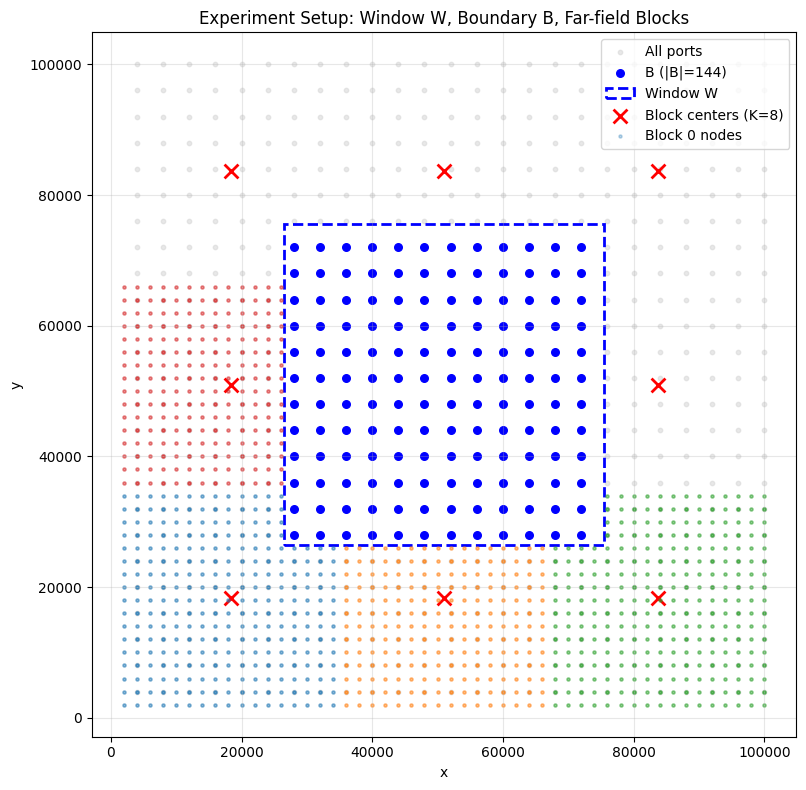

In [8]:
# Visualize the setup
fig, ax = plt.subplots(figsize=(10, 8))

# Plot all ports (light gray)
all_port_coords = np.array([port_coords[p] for p in port_coords])
ax.scatter(all_port_coords[:, 0], all_port_coords[:, 1], 
           c='lightgray', s=10, alpha=0.5, label='All ports')

# Plot boundary ports B (blue)
boundary_coords = np.array([port_coords[p] for p in boundary_ports])
ax.scatter(boundary_coords[:, 0], boundary_coords[:, 1], 
           c='blue', s=30, label=f'B (|B|={len(boundary_ports)})')

# Plot window rectangle
wx_min, wx_max, wy_min, wy_max = window_bounds
rect = plt.Rectangle((wx_min, wy_min), wx_max - wx_min, wy_max - wy_min,
                     fill=False, edgecolor='blue', linewidth=2, linestyle='--', label='Window W')
ax.add_patch(rect)

# Plot block centers
if block_centers:
    bc = np.array(block_centers)
    ax.scatter(bc[:, 0], bc[:, 1], c='red', s=100, marker='x', 
               linewidths=2, label=f'Block centers (K={len(blocks)})')

# Plot far-field nodes (sample)
for i, block in enumerate(blocks[:4]):  # Show first 4 blocks
    block_coords = np.array([bottom_coords[n] for n in block if n in bottom_coords])
    if len(block_coords) > 0:
        ax.scatter(block_coords[:, 0], block_coords[:, 1], 
                   s=5, alpha=0.3, label=f'Block {i} nodes' if i == 0 else None)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Experiment Setup: Window W, Boundary B, Far-field Blocks')
ax.legend(loc='upper right')
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Generate Injection Patterns

For each far-field block, we generate:
- 1 uniform pattern: current distributed equally among all nodes
- N random patterns: random weights normalized to total current

In [9]:
# Configuration
N_RANDOM_PATTERNS = 3
TOTAL_CURRENT = 1000.0  # mA (1A per block)
SEED = 42

# Generate injection patterns
patterns, block_indices = generate_block_injections(
    blocks, N_RANDOM_PATTERNS, TOTAL_CURRENT, SEED
)

print(f"Total patterns: {len(patterns)}")
print(f"  Per block: 1 uniform + {N_RANDOM_PATTERNS} random = {1 + N_RANDOM_PATTERNS}")
print(f"  Total current per pattern: {TOTAL_CURRENT} mA")

Total patterns: 32
  Per block: 1 uniform + 3 random = 4
  Total current per pattern: 1000.0 mA


In [10]:
# Examine a sample pattern
sample_pattern = patterns[2]  # First uniform pattern from block 0
print(f"Sample pattern (Block 0, uniform):")
print(f"  Nodes: {len(sample_pattern)}")
print(f"  Total current: {sum(sample_pattern.values()):.2f} mA")
print(f"  Current per node: {list(sample_pattern.values())[0]:.4f} mA")

Sample pattern (Block 0, uniform):
  Nodes: 606
  Total current: 1000.00 mA
  Current per node: 2.8513 mA


## 6. Solve Coupled System and Extract Boundary Responses

For each injection pattern, solve the coupled hierarchical system and extract boundary port voltages.

In [11]:
%%time
# Compute boundary response matrix H
# H[:, k] = boundary voltages for pattern k

H = compute_boundary_response_matrix(
    solver, patterns, boundary_ports, PARTITION_LAYER, verbose=True
)

print(f"\nH shape: {H.shape}")
print(f"  Rows (|B|): {H.shape[0]} boundary ports")
print(f"  Cols: {H.shape[1]} injection patterns")

  Solving pattern 1/32...
  Solving pattern 2/32...
  Solving pattern 3/32...
  Solving pattern 4/32...
  Solving pattern 5/32...
  Solving pattern 6/32...
  Solving pattern 7/32...
  Solving pattern 8/32...
  Solving pattern 9/32...
  Solving pattern 10/32...
  Solving pattern 11/32...
  Solving pattern 12/32...
  Solving pattern 13/32...
  Solving pattern 14/32...
  Solving pattern 15/32...
  Solving pattern 16/32...
  Solving pattern 17/32...
  Solving pattern 18/32...
  Solving pattern 19/32...
  Solving pattern 20/32...
  Solving pattern 21/32...
  Solving pattern 22/32...
  Solving pattern 23/32...
  Solving pattern 24/32...
  Solving pattern 25/32...
  Solving pattern 26/32...
  Solving pattern 27/32...
  Solving pattern 28/32...
  Solving pattern 29/32...
  Solving pattern 30/32...


KeyboardInterrupt: 

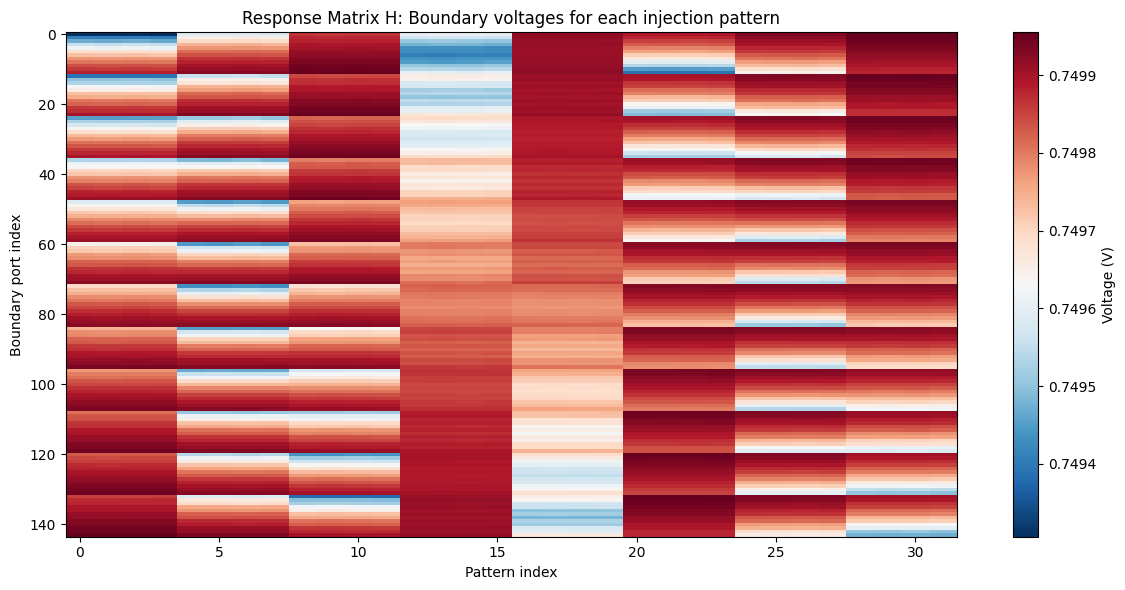

In [ ]:
# Visualize H matrix
fig, ax = plt.subplots(figsize=(12, 6))
im = ax.imshow(H, aspect='auto', cmap='RdBu_r')
plt.colorbar(im, ax=ax, label='Voltage (V)')
ax.set_xlabel('Pattern index')
ax.set_ylabel('Boundary port index')
ax.set_title('Response Matrix H: Boundary voltages for each injection pattern')
plt.tight_layout()
plt.show()

## 7. SVD Analysis

Compute the SVD of H and analyze the singular value spectrum.

In [ ]:
# Analyze response matrix
results = analyze_response_matrix(H, boundary_ports, port_coords)

sigma = results['singular_values']
U = results['U']
Vt = results['Vt']

print("SVD Results:")
print(f"  Effective rank (1% threshold): {results['effective_rank_1pct']}")
print(f"  Effective rank (0.1% threshold): {results['effective_rank_01pct']}")
print(f"  Rank for 90% energy: {results['rank_90pct_energy']}")
print(f"  Rank for 95% energy: {results['rank_95pct_energy']}")
print(f"  Rank for 99% energy: {results['rank_99pct_energy']}")
print(f"  Decay rate: {results['decay_rate']:.3f}")
print(f"  Compression ratio (99%): {results['compression_ratio_99pct']:.1f}x")

SVD Results:
  Effective rank (1% threshold): 1
  Effective rank (0.1% threshold): 1
  Rank for 90% energy: 1
  Rank for 95% energy: 1
  Rank for 99% energy: 1
  Decay rate: 0.183
  Compression ratio (99%): 144.0x


In [ ]:
# Print top singular values
print("\nTop 10 singular values:")
for i, s in enumerate(sigma[:10]):
    pct = s / sigma[0] * 100
    print(f"  σ_{i+1:2d} = {s:12.4e}  ({pct:8.4f}%)")


Top 10 singular values:
  σ_ 1 =   5.0898e+01  (100.0000%)
  σ_ 2 =   5.5348e-03  (  0.0109%)
  σ_ 3 =   5.1844e-03  (  0.0102%)
  σ_ 4 =   1.9766e-03  (  0.0039%)
  σ_ 5 =   1.6184e-03  (  0.0032%)
  σ_ 6 =   7.2254e-04  (  0.0014%)
  σ_ 7 =   6.1681e-04  (  0.0012%)
  σ_ 8 =   3.9778e-04  (  0.0008%)
  σ_ 9 =   1.1390e-05  (  0.0000%)
  σ_10 =   7.4238e-06  (  0.0000%)


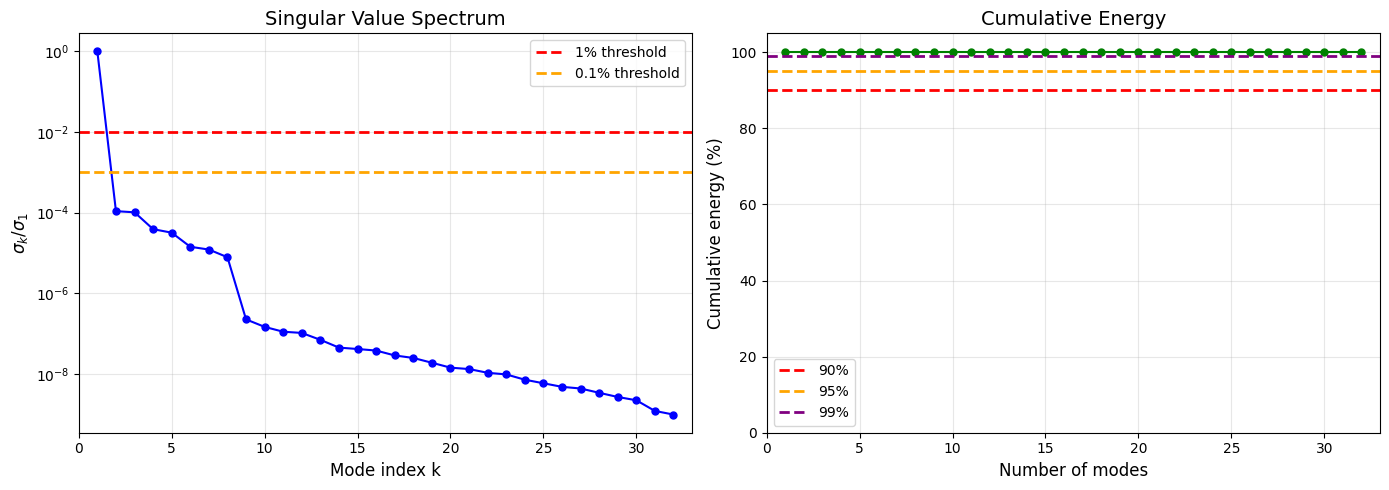

In [ ]:
# Plot singular value spectrum
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Normalized singular values (log scale)
ax = axes[0]
sigma_norm = sigma / sigma[0]
ax.semilogy(np.arange(len(sigma_norm)) + 1, sigma_norm, 'b.-', markersize=10)
ax.axhline(0.01, color='r', linestyle='--', linewidth=2, label='1% threshold')
ax.axhline(0.001, color='orange', linestyle='--', linewidth=2, label='0.1% threshold')
ax.set_xlabel('Mode index k', fontsize=12)
ax.set_ylabel(r'$\sigma_k / \sigma_1$', fontsize=12)
ax.set_title('Singular Value Spectrum', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, len(sigma_norm) + 1)

# Cumulative energy
ax = axes[1]
cum_energy = results['cumulative_energy']
ax.plot(np.arange(len(cum_energy)) + 1, cum_energy * 100, 'g.-', markersize=10)
ax.axhline(90, color='r', linestyle='--', linewidth=2, label='90%')
ax.axhline(95, color='orange', linestyle='--', linewidth=2, label='95%')
ax.axhline(99, color='purple', linestyle='--', linewidth=2, label='99%')
ax.set_xlabel('Number of modes', fontsize=12)
ax.set_ylabel('Cumulative energy (%)', fontsize=12)
ax.set_title('Cumulative Energy', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, len(cum_energy) + 1)
ax.set_ylim(0, 105)

plt.tight_layout()
plt.show()

## 8. Visualize Dominant Boundary Voltage Patterns

The left singular vectors U[:, k] represent the principal boundary voltage patterns.

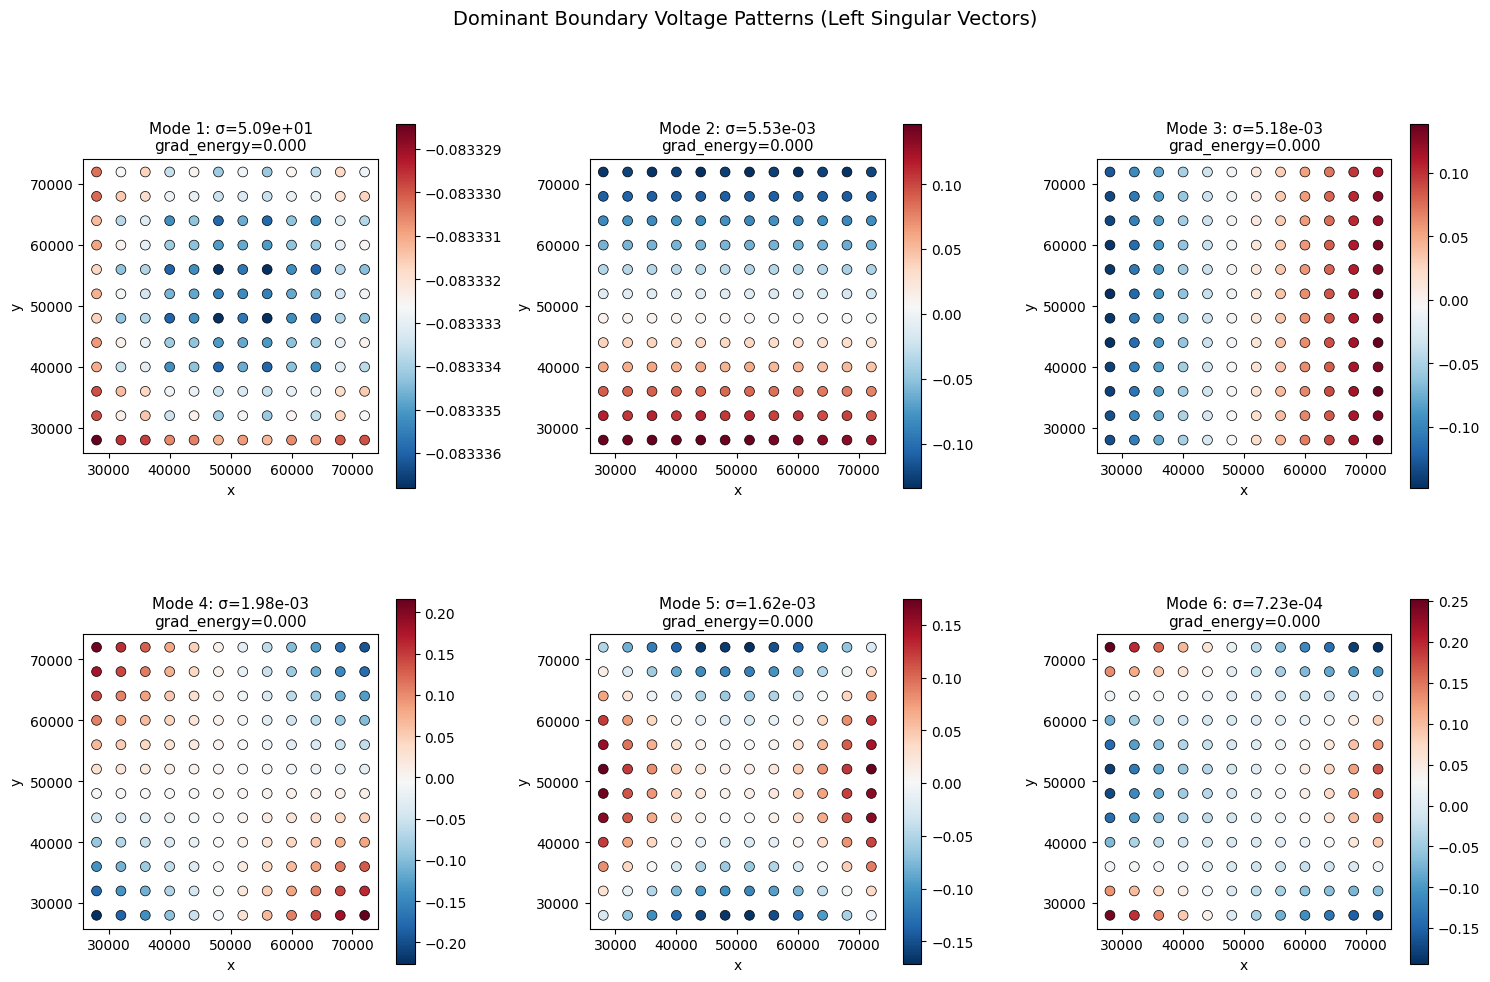

In [ ]:
# Plot dominant modes
n_modes = min(6, U.shape[1])
boundary_coords_arr = np.array([port_coords[p] for p in boundary_ports])

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i in range(n_modes):
    ax = axes[i]
    u = U[:, i]
    
    sc = ax.scatter(boundary_coords_arr[:, 0], boundary_coords_arr[:, 1], 
                   c=u, cmap='RdBu_r', s=50, edgecolors='k', linewidths=0.5)
    plt.colorbar(sc, ax=ax, shrink=0.8)
    
    smoothness = results['smoothness_scores'][i] if i < len(results['smoothness_scores']) else {}
    grad_energy = smoothness.get('gradient_energy', 0)
    
    ax.set_title(f'Mode {i+1}: σ={sigma[i]:.2e}\ngrad_energy={grad_energy:.3f}', fontsize=11)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_aspect('equal')

plt.suptitle('Dominant Boundary Voltage Patterns (Left Singular Vectors)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 9. Validation Against Flat Solve

Verify that the coupled hierarchical solver produces correct results by comparing against the flat (non-hierarchical) solver.

In [ ]:
%%time
# Validate against flat solve (this takes longer)
validation = validate_against_flat_solve(
    solver, patterns, boundary_ports, H, verbose=True
)

print(f"\nValidation Results:")
print(f"  Max diff: {validation['max_diff_mV']:.6f} mV")
print(f"  Mean diff: {validation['mean_diff_mV']:.6f} mV")
print(f"  RMSE: {validation['rmse']*1000:.6f} mV")

  Flat solve pattern 1/32...
  Flat solve pattern 2/32...
  Flat solve pattern 3/32...
  Flat solve pattern 4/32...
  Flat solve pattern 5/32...
  Flat solve pattern 6/32...
  Flat solve pattern 7/32...
  Flat solve pattern 8/32...
  Flat solve pattern 9/32...
  Flat solve pattern 10/32...
  Flat solve pattern 11/32...
  Flat solve pattern 12/32...
  Flat solve pattern 13/32...
  Flat solve pattern 14/32...
  Flat solve pattern 15/32...
  Flat solve pattern 16/32...
  Flat solve pattern 17/32...
  Flat solve pattern 18/32...
  Flat solve pattern 19/32...
  Flat solve pattern 20/32...
  Flat solve pattern 21/32...
  Flat solve pattern 22/32...
  Flat solve pattern 23/32...
  Flat solve pattern 24/32...
  Flat solve pattern 25/32...
  Flat solve pattern 26/32...
  Flat solve pattern 27/32...
  Flat solve pattern 28/32...
  Flat solve pattern 29/32...
  Flat solve pattern 30/32...
  Flat solve pattern 31/32...
  Flat solve pattern 32/32...

Validation Results:
  Max diff: 0.000385 mV
  Me

## 10. Window Size Scaling Analysis

How does the effective rank scale with window size?

In [ ]:
# Sweep window sizes
window_fractions = [0.10, 0.15, 0.20, 0.25, 0.30, 0.40, 0.50]
size_results = []

for frac in window_fractions:
    print(f"Window fraction: {frac*100:.0f}%")
    
    # Compute window bounds
    wb = compute_window_bounds(port_coords, grid_bounds, 'center', frac)
    
    # Define boundary
    _, bp_list = define_window_and_boundary(port_nodes, port_coords, wb)
    
    if len(bp_list) == 0:
        print("  No ports in window, skipping")
        continue
    
    # Partition far-field
    blks, _ = partition_farfield_into_blocks(
        tile_manager, bottom_nodes, bottom_coords, wb, grid_bounds, 3, 3
    )
    
    if len(blks) == 0:
        print("  No far-field blocks, skipping")
        continue
    
    # Generate patterns and compute H
    pats, _ = generate_block_injections(blks, N_RANDOM_PATTERNS, TOTAL_CURRENT, SEED)
    H_sweep = compute_boundary_response_matrix(solver, pats, bp_list, PARTITION_LAYER, verbose=False)
    
    # Analyze
    res = analyze_response_matrix(H_sweep, bp_list, port_coords)
    
    size_results.append({
        'fraction': frac,
        'n_boundary': len(bp_list),
        'rank_1pct': res['effective_rank_1pct'],
        'rank_99pct': res['rank_99pct_energy'],
        'compression': res['compression_ratio_99pct'],
    })
    
    print(f"  |B|={len(bp_list)}, rank(1%)={res['effective_rank_1pct']}, rank(99%)={res['rank_99pct_energy']}")

Window fraction: 10%
  |B|=64, rank(1%)=1, rank(99%)=1
Window fraction: 15%
  |B|=81, rank(1%)=1, rank(99%)=1
Window fraction: 20%
  |B|=121, rank(1%)=1, rank(99%)=1
Window fraction: 25%
  |B|=144, rank(1%)=1, rank(99%)=1
Window fraction: 30%
  |B|=169, rank(1%)=1, rank(99%)=1
Window fraction: 40%
  |B|=225, rank(1%)=1, rank(99%)=1
Window fraction: 50%
  |B|=289, rank(1%)=1, rank(99%)=1


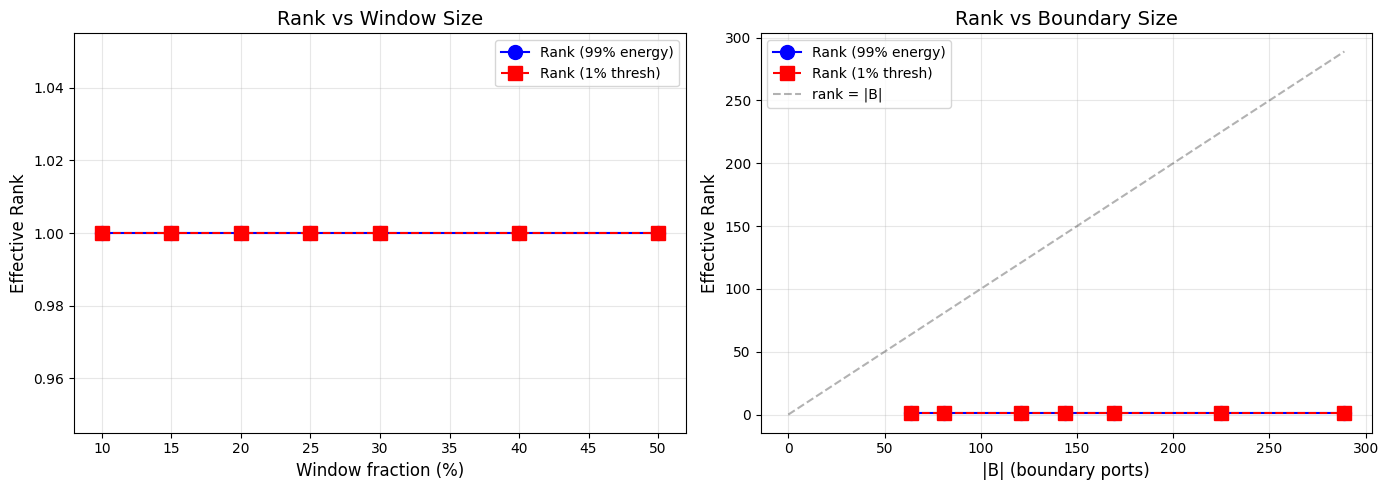

In [ ]:
# Plot size sweep results
if size_results:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    fracs = [r['fraction'] for r in size_results]
    n_boundary = [r['n_boundary'] for r in size_results]
    rank_99 = [r['rank_99pct'] for r in size_results]
    rank_1 = [r['rank_1pct'] for r in size_results]
    
    # Rank vs fraction
    ax = axes[0]
    ax.plot(np.array(fracs) * 100, rank_99, 'bo-', markersize=10, label='Rank (99% energy)')
    ax.plot(np.array(fracs) * 100, rank_1, 'rs--', markersize=10, label='Rank (1% thresh)')
    ax.set_xlabel('Window fraction (%)', fontsize=12)
    ax.set_ylabel('Effective Rank', fontsize=12)
    ax.set_title('Rank vs Window Size', fontsize=14)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Rank vs |B|
    ax = axes[1]
    ax.plot(n_boundary, rank_99, 'bo-', markersize=10, label='Rank (99% energy)')
    ax.plot(n_boundary, rank_1, 'rs--', markersize=10, label='Rank (1% thresh)')
    ax.plot([0, max(n_boundary)], [0, max(n_boundary)], 'k--', alpha=0.3, label='rank = |B|')
    ax.set_xlabel('|B| (boundary ports)', fontsize=12)
    ax.set_ylabel('Effective Rank', fontsize=12)
    ax.set_title('Rank vs Boundary Size', fontsize=14)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 11. Distance Ring Analysis

How does the effective rank vary with distance from the window?

In [ ]:
# Partition far-field by distance rings
N_RINGS = 4
rings = partition_farfield_by_distance_rings(
    bottom_nodes, bottom_coords, window_bounds, grid_bounds, N_RINGS
)

print(f"Distance rings ({N_RINGS} rings):")
for i, ring in enumerate(rings):
    print(f"  Ring {i}: {len(ring)} nodes")

Distance rings (4 rings):
  Ring 0: 720 nodes
  Ring 1: 855 nodes
  Ring 2: 990 nodes
  Ring 3: 1764 nodes


In [ ]:
# Analyze each ring separately
ring_results = []

for ring_idx, ring_nodes in enumerate(rings):
    if len(ring_nodes) == 0:
        print(f"Ring {ring_idx}: empty")
        ring_results.append(None)
        continue
    
    print(f"Ring {ring_idx}: {len(ring_nodes)} nodes")
    
    # Generate patterns for this ring only
    pats, _ = generate_block_injections([ring_nodes], N_RANDOM_PATTERNS, TOTAL_CURRENT, SEED)
    
    # Compute response
    H_ring = compute_boundary_response_matrix(solver, pats, boundary_ports, PARTITION_LAYER, verbose=False)
    
    # Analyze
    res = analyze_response_matrix(H_ring, boundary_ports, port_coords)
    
    ring_results.append({
        'n_nodes': len(ring_nodes),
        'rank_1pct': res['effective_rank_1pct'],
        'rank_99pct': res['rank_99pct_energy'],
        'sigma': res['singular_values'],
    })
    
    print(f"  rank(1%)={res['effective_rank_1pct']}, rank(99%)={res['rank_99pct_energy']}")

Ring 0: 720 nodes
  rank(1%)=1, rank(99%)=1
Ring 1: 855 nodes
  rank(1%)=1, rank(99%)=1
Ring 2: 990 nodes
  rank(1%)=1, rank(99%)=1
Ring 3: 1764 nodes
  rank(1%)=1, rank(99%)=1


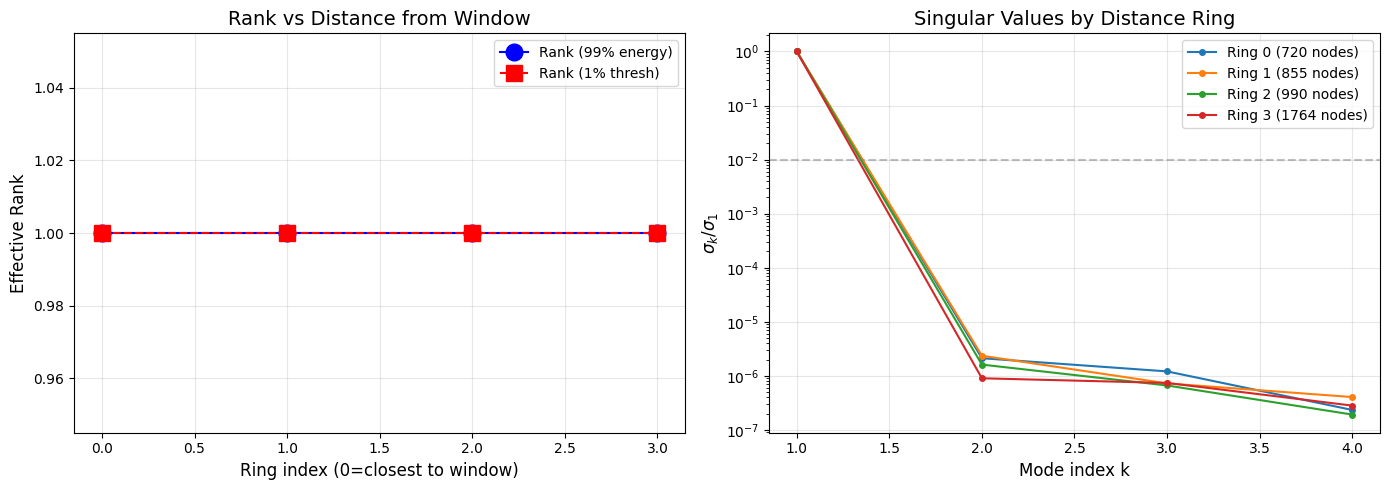

In [ ]:
# Plot distance ring analysis
valid_rings = [(i, r) for i, r in enumerate(ring_results) if r is not None]

if valid_rings:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Rank vs ring index
    ax = axes[0]
    ring_indices = [i for i, _ in valid_rings]
    ranks_99 = [r['rank_99pct'] for _, r in valid_rings]
    ranks_1 = [r['rank_1pct'] for _, r in valid_rings]
    
    ax.plot(ring_indices, ranks_99, 'bo-', markersize=12, label='Rank (99% energy)')
    ax.plot(ring_indices, ranks_1, 'rs--', markersize=12, label='Rank (1% thresh)')
    ax.set_xlabel('Ring index (0=closest to window)', fontsize=12)
    ax.set_ylabel('Effective Rank', fontsize=12)
    ax.set_title('Rank vs Distance from Window', fontsize=14)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Singular value spectra
    ax = axes[1]
    for i, r in valid_rings:
        sigma_ring = r['sigma']
        if len(sigma_ring) > 0:
            sigma_norm = sigma_ring / sigma_ring[0]
            ax.semilogy(np.arange(len(sigma_norm)) + 1, sigma_norm, '.-',
                       label=f'Ring {i} ({r["n_nodes"]} nodes)', markersize=8)
    
    ax.axhline(0.01, color='gray', linestyle='--', alpha=0.5)
    ax.set_xlabel('Mode index k', fontsize=12)
    ax.set_ylabel(r'$\sigma_k / \sigma_1$', fontsize=12)
    ax.set_title('Singular Values by Distance Ring', fontsize=14)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 12. Summary and Conclusions

In [ ]:
print("=" * 70)
print("ANALYSIS SUMMARY")
print("=" * 70)

print(f"\nConfiguration:")
print(f"  Netlist: {NETLIST_PATH}")
print(f"  Net: {NET_NAME}")
print(f"  Partition layer: {PARTITION_LAYER}")
print(f"  Window: {WINDOW_POSITION}, {WINDOW_FRACTION*100:.0f}%")
print(f"  Total current per pattern: {TOTAL_CURRENT} mA")

print(f"\nGrid Statistics:")
print(f"  Top nodes: {len(top_nodes)}")
print(f"  Bottom nodes: {len(bottom_nodes)}")
print(f"  Port nodes: {len(port_nodes)}")
print(f"  Boundary ports |B|: {len(boundary_ports)}")

print(f"\nSVD Results:")
print(f"  Effective rank (1%): {results['effective_rank_1pct']}")
print(f"  Rank for 99% energy: {results['rank_99pct_energy']}")
print(f"  Compression ratio: {results['compression_ratio_99pct']:.1f}x")
print(f"  σ₁ = {sigma[0]:.4e}")
print(f"  σ₂ = {sigma[1]:.4e} ({sigma[1]/sigma[0]*100:.6f}% of σ₁)")

print("\n" + "-" * 70)
if results['rank_99pct_energy'] < len(boundary_ports) * 0.1:
    print("CONCLUSION: Far-field coupling is EXTREMELY LOW-RANK")
    print(f"  Only {results['rank_99pct_energy']} mode(s) capture 99% of energy")
    print(f"  Compression ratio: {results['compression_ratio_99pct']:.0f}x")
    print("\n  Implication: Far-field switching produces essentially a single")
    print("  smooth pattern at the local boundary. Hierarchical approximations")
    print("  that capture this mode are highly justified.")
elif results['rank_99pct_energy'] < len(boundary_ports) * 0.3:
    print("CONCLUSION: Far-field coupling is LOW-RANK")
else:
    print("CONCLUSION: Far-field coupling has MODERATE to HIGH rank")

ANALYSIS SUMMARY

Configuration:
  Netlist: ../pdn/netlist_small
  Net: VDD_XLV
  Partition layer: M4
  Window: center, 25%
  Total current per pattern: 1000.0 mA

Grid Statistics:
  Top nodes: 914
  Bottom nodes: 5625
  Port nodes: 625
  Boundary ports |B|: 144

SVD Results:
  Effective rank (1%): 1
  Rank for 99% energy: 1
  Compression ratio: 144.0x
  σ₁ = 5.0898e+01
  σ₂ = 5.5348e-03 (0.010874% of σ₁)

----------------------------------------------------------------------
CONCLUSION: Far-field coupling is EXTREMELY LOW-RANK
  Only 1 mode(s) capture 99% of energy
  Compression ratio: 144x

  Implication: Far-field switching produces essentially a single
  smooth pattern at the local boundary. Hierarchical approximations
  that capture this mode are highly justified.


## 13. Quick Analysis with run_farfield_analysis()

For convenience, all the above steps can be done with a single function call:

In [ ]:
# Quick analysis using the convenience function
quick_results = run_farfield_analysis(
    solver,
    partition_layer='M4',
    window_position='center',
    window_fraction=0.25,
    n_blocks_x=3,
    n_blocks_y=3,
    n_random_patterns=3,
    total_current=1000.0,
    seed=42,
    validate=False,
    verbose=True,
)

Setting up analysis...
  Partition layer: M4
  Top nodes: 914, Bottom nodes: 5625, Ports: 625
  Grid bounds: x=[2000, 100000], y=[2000, 100000]
  Window (center, 25%): x=[26500, 75500], y=[26500, 75500]
  Boundary ports |B|: 144
  Far-field blocks: 8
    Block 0: 606 nodes
    Block 1: 464 nodes
    Block 2: 614 nodes
    Block 3: 464 nodes
    Block 4: 472 nodes
    Block 5: 614 nodes
    Block 6: 472 nodes
    Block 7: 623 nodes
  Total injection patterns: 32
Computing boundary response matrix H...
  Solving pattern 1/32...
  Solving pattern 2/32...
  Solving pattern 3/32...
  Solving pattern 4/32...
  Solving pattern 5/32...
  Solving pattern 6/32...
  Solving pattern 7/32...
  Solving pattern 8/32...
  Solving pattern 9/32...
  Solving pattern 10/32...
  Solving pattern 11/32...
  Solving pattern 12/32...
  Solving pattern 13/32...
  Solving pattern 14/32...
  Solving pattern 15/32...
  Solving pattern 16/32...
  Solving pattern 17/32...
  Solving pattern 18/32...
  Solving pattern